In [1]:
import os
import cv2
from paddleocr import PPStructure,save_structure_res
from paddleocr.ppstructure.recovery.recovery_to_doc import sorted_layout_boxes, convert_info_docx
import pandas as pd
import matplotlib.pyplot as plt
from tablepyxl import tablepyxl
from copy import deepcopy
import numpy as np
import io

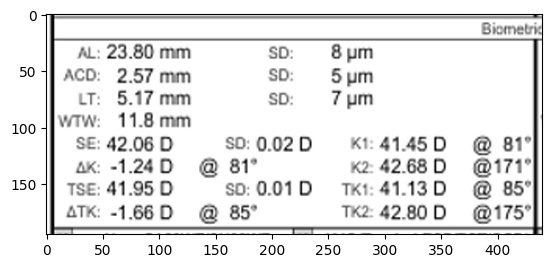

In [93]:
#read image table
path = 'Sample/IOL.png'
img = cv2.imread(path)
img = cv2.resize(img, (1000, 1500), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
img = img[600:795, 80:520]
plt.imshow(img)

In [ ]:
# read circle
path = 'Sample/S__33579013.jpg'
img = cv2.imread(path)
img = cv2.resize(img, (1600, 1100), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
img = img[400:800 , 750:1050]
plt.imshow(img)

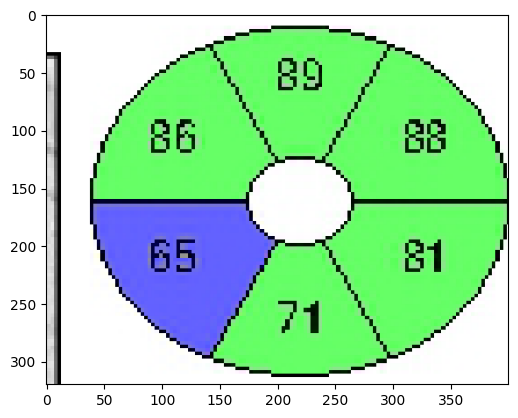

In [89]:
# ocr circle
path = 'Sample/out.png'
img = cv2.imread(path)
# img = cv2.resize(img, (1600, 1100), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
img = img[1530:1850, 800:1200]
plt.imshow(img)

In [39]:
tmp = {
    "name1": [
        {
            "id": "circle_right",
            "type": "image",
            "box_pos": [800, 1530, 1200, 1850]  # x1, y1, x2, y2
        },
        {
            "id": "circle_left",
            "type": "image",
            "box_pos": [1500, 1530, 1900, 1850]
        }
    ],
    "name2": [
        {
            "id": "name",
            "type": "text",
            "box_pos": [127.440, 741.671, 204.817, 749.921]
        },
        {
            "id": "id",
            "type": "text",
            "box_pos": [127.440, 721.511, 164.136, 729.761]
        },
        {
            "id": "DOB",
            "type": "text",
            "box_pos": [127.440, 708.551, 164.119, 716.801]
        }
    ]
}

In [40]:
data_input = [{
        "template_name": tmp['name1'],
        "path": 'Sample/out.png',
        "page": 1,
}]

In [88]:
# load model
def load_model():
    """
    load model from paddleocr (PPStructure)

    Returns:
        tabular engine model
    """
    table_engine = PPStructure(recovery=True, lang='en')
    return table_engine

def predict(table_engine, image):
    """
    predict table from image

    Args:
        table_engine: tabular engine model
        image: input image

    Returns:
        result of prediction
    """
    result = table_engine(image)
    return result

def process_result(result):
    """
    process result from prediction

    Args:
        result: result of prediction

    Returns:
        dataframe from result
    """
    result_cp = deepcopy(result)
    df_ls = []
    for region in result_cp:
        # if region is table
        if 'html' in region['res']:
            html = region['res']['html']
            wb = tablepyxl.document_to_workbook(html)
            output = io.BytesIO()
            wb.save(output)
            output.seek(0)
            df = pd.read_excel(output, header=None)
            df_ls.append(df)
        # else region is circle
        else:
            text_ls = []
            for text in region['res']:
                text_ls.append(text['text'])
            df = pd.DataFrame(text_ls)
            df_ls.append(df)
            
    return pd.concat(df_ls, axis=0) 


In [26]:
table_engine = load_model()

[2023/12/11 01:49:32] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\earth/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\earth/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_leng

In [138]:
# inference
df_predict_ls = []
for page_index in range(len(data_input)):
    page = data_input[page_index]
    image_path = page['path']
    image = cv2.imread(image_path)
    
    for box_index in range(len(page['template_name'])):
        x1, y1, x2, y2 = page['template_name'][box_index]['box_pos']
        roi_image = image[y1:y2, x1:x2]
        result = predict(table_engine, roi_image)
        df_predict = process_result(result)
        columns_ls = [page['template_name'][box_index]['id']] * (len(df_predict.columns))
        df_predict.columns = columns_ls
        df_predict_ls.append(df_predict)

pd.concat(df_predict_ls, axis=1)


def inference(data_input, engine):
    """
    inference from input data

    Args:
        data_input (dict): input data
        engine : engine model

    Returns:
        dataframe from result    
    """
    df_predict_ls = []
    for page_index in range(len(data_input)):
        page = data_input[page_index]
        image_path = page['path']
        image = cv2.imread(image_path)
        
        for box_index in range(len(page['template_name'])):
            x1, y1, x2, y2 = page['template_name'][box_index]['box_pos']
            roi_image = image[y1:y2, x1:x2]
            result = predict(table_engine, roi_image)
            df_predict = process_result(result)
            columns_ls = [page['template_name'][box_index]['id']] * (len(df_predict.columns))
            df_predict.columns = columns_ls
            df_predict_ls.append(df_predict)
            
    return pd.concat(df_predict_ls, axis=1)

[2023/12/11 14:27:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0206453800201416
[2023/12/11 14:27:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.10260272026062012
[2023/12/11 14:27:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.017760038375854492
[2023/12/11 14:27:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.10890436172485352


In [139]:
inference(data_input, table_engine)

[2023/12/11 14:30:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.018520593643188477
[2023/12/11 14:30:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.09953022003173828
[2023/12/11 14:30:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.01834893226623535
[2023/12/11 14:30:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.09813857078552246


,circle_right,circle_left
0,89,108
1,86,101
2,88,87
3,65,75
4,81,62
5,71,58


In [161]:
# predict
result = table_engine(img)        
result_cp = deepcopy(result)
region = result_cp[0]
roi_img = region.pop('img')
# html = region['res']['html']
# wb = tablepyxl.document_to_workbook(html)

[2023/12/10 23:06:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.01308441162109375
[2023/12/10 23:06:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.015427112579345703


In [97]:
# predict
result = table_engine(img)        
result_cp = deepcopy(result)

df_ls = []
for region in result_cp:
    # if region is table
    if 'html' in region['res']:
        html = region['res']['html']
        wb = tablepyxl.document_to_workbook(html)
        output = io.BytesIO()
        wb.save(output)
        output.seek(0)
        df = pd.read_excel(output, header=None)
        df_ls.append(df)
    # else region is circle
    else:
        text_ls = []
        for text in region['res']:
            text_ls.append(text['text'])
        df = pd.DataFrame(text_ls)
        df_ls.append(df)
        
tmp = pd.concat(df_ls, axis=0)
tmp

[2023/12/11 02:24:03] ppocr DEBUG: dt_boxes num : 29, elapse : 0.05342841148376465
[2023/12/11 02:24:03] ppocr DEBUG: rec_res num  : 29, elapse : 0.07335042953491211


,0,1,2,3
0,NaN,NaN,NaN,Biometri
1,AL: 23.80 mm,NaN,SD: 8 m,NaN
2,ACD:2.57 mm,NaN,SD: 5 m,NaN
3,LT: 5.17 mm,NaN,7 m,NaN
4,WTW: 11.8 mm,NaN,NaN,NaN
5,SE: 42.06 D,SD: SD: 0.02 D,K1: 41.45 D,0.:1
6,K:-1.24 D,@ 81,K2: 42.68 D,@71
7,TSE: 41.95 D,SD: 0.01 D,TK1: 41.13 D,@ 85
8,TK: -1.66 D,@ 85,TK2: 42.80 D,@175
